# Credits

See main readme for credits.

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28x28=784$.
That is, we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (Your are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## Ballpark estimates of hyperparameters
__Optimizers:__
    1. SGD + Momentum: learning rate 1.0 - 0.1 
    2. ADAM: learning rate 3*1e-4 - 1e-5
    3. RMSPROP: somewhere between SGD and ADAM

__Regularization:__
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
2. L2 (weight decay of optimization functions, e.g. [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam)) and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss).
  - Not used that often in deep learning, but 1e-4  -  1e-8
3. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    
    
__Parameter initialization__
Parameter initialization is extremely important. TensorFlow has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaming He
2. Xavier Glorot
3. Uniform or Normal with small scale. (0.1 - 0.01)
4. Orthogonal (I find that this works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Number of hidden units and network structure__
Probably as big network as possible and then apply regularization. You'll have to experiment. One rarely goes below 512 units for feedforward networks unless your are training on CPU...
Theres is some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Nonlinearity__: [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
    
1. ReLU
2. Leaky ReLU
3. Elu
3. Sigmoids are used if your output is binary. It is not used in the hidden layers. Squases the output between -1 and 1
4. Softmax used as output if you have a classification problem. Normalizes the the output to 1.

See the plot below.

__Mini-batch size__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory -> you can train a model with more parameters.

Hyperparameters can be found by experience (guessing) or some search procedure. Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [SPEARMINT](https://github.com/JasperSnoek/spearmint) and many others.

1.0


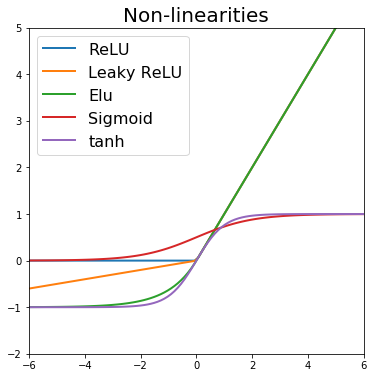

In [2]:
# PLOT OF DIFFERENT OUTPUT UNITS
x = np.linspace(-6, 6, 100)
relu = lambda x: np.maximum(0, x)
# probably a slow implementation..
leaky_relu = lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x)
elu = lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1) 
sigmoid = lambda x: (1 + np.exp(-x))**(-1)

tanh = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def softmax(w, t = 1.0):
    e = np.exp(w)
    return e / np.sum(e)

x_softmax = softmax(x)

plt.figure(figsize=(6, 6))
plt.plot(x, relu(x), label='ReLU', lw=2)
plt.plot(x, leaky_relu(x), label='Leaky ReLU',lw=2)
plt.plot(x, elu(x), label='Elu', lw=2)
plt.plot(x, sigmoid(x), label='Sigmoid',lw=2)
plt.plot(x, tanh(x), label='tanh',lw=2)
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# softmax
# assert that all class probablities sum to one
print(np.sum(x_softmax))
assert abs(1.0 - x_softmax.sum()) < 1e-8

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [10]:
!if [ ! -f mnist.npz ]; then wget -N https://www.dropbox.com/s/qxywaq7nx19z72p/mnist.npz; else echo "mnist.npz already downloaded"; fi

already downloaded


In [3]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 784)
targets_train (1000,)
x_valid (500, 784)
targets_valid (500,)
x_test (500, 784)
targets_test (500,)


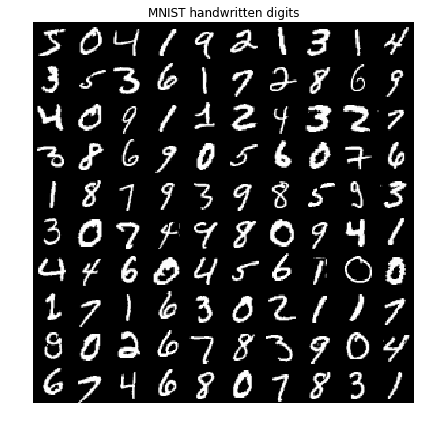

In [4]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [5]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal(torch.Tensor(num_output, num_hidden)))
        self.b_2 = Parameter(init.constant(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)


net = Net(num_features, num_l1, num_classes)

In [6]:
optimizer = optim.SGD(net.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, 28*28)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 10])


# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converges much faster using minibatches because the paramters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch 1 : Train Loss 2.284713e-01 , Train acc 0.312000,  Valid acc 0.322000 
Epoch 11 : Train Loss 1.864607e-01 , Train acc 0.650000,  Valid acc 0.612000 
Epoch 21 : Train Loss 1.740874e-01 , Train acc 0.800000,  Valid acc 0.734000 
Epoch 31 : Train Loss 1.675607e-01 , Train acc 0.847000,  Valid acc 0.758000 
Epoch 41 : Train Loss 1.634644e-01 , Train acc 0.873000,  Valid acc 0.778000 
Epoch 51 : Train Loss 1.607417e-01 , Train acc 0.899000,  Valid acc 0.802000 
Epoch 61 : Train Loss 1.581216e-01 , Train acc 0.921000,  Valid acc 0.814000 
Epoch 71 : Train Loss 1.564890e-01 , Train acc 0.933000,  Valid acc 0.820000 
Epoch 81 : Train Loss 1.553800e-01 , Train acc 0.943000,  Valid acc 0.820000 
Epoch 91 : Train Loss 1.545506e-01 , Train acc 0.947000,  Valid acc 0.820000 


(Text(0.5,0,'Updates'), Text(0,0.5,'Acc'))

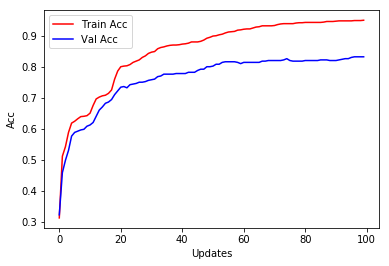

In [8]:
# using confusionmatrix to handle 
from confusionmatrix import ConfusionMatrix

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []

## TRAINING ##
for epoch in range(num_epochs):
    #Forward->Backprob->Update params
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        idx = range(i * batch_size, (i + 1) * batch_size)
        x_batch = x_train[idx]
        x_batch = Variable(torch.from_numpy(x_batch))
        target_batch = targets_train[idx]
        target_batch = Variable(torch.from_numpy(target_batch).long())
        
        optimizer.zero_grad()
    
        output = net(x_batch)
        batch_loss = criterion(output, target_batch)
        
        # compute gradients given loss
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss
    loss.append(cur_loss / batch_size)
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    net.eval()
    ### EVAL - TRAIN ###
    for i in range(num_batches_train):
        idx = range(i * batch_size, (i + 1) * batch_size)
        x_batch = x_train[idx]
        x_batch = Variable(torch.from_numpy(x_batch))
        targets_batch = targets_train[idx]
        targets_batch = Variable(torch.from_numpy(targets_batch))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        confusion_train.batch_add(targets_batch.data.numpy(), preds.data.numpy())

    ### EVAL - VALIDATION ###
    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_valid[idx]
        x_batch = Variable(torch.from_numpy(x_batch))
        targets_batch = targets_valid[idx]
        targets_batch = Variable(torch.from_numpy(targets_batch))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        confusion_valid.batch_add(targets_batch.data.numpy(), preds.data.numpy())
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
                % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))
    
    
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Questions

Try and add these modifications:
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add dropout to the network (NOTE the `net.train()` and `net.eval()` already in the code)
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent
- add L2/weight decay to the optimizer
- add L1 regularization